#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

# **0.미션**

* 단계1 다양한 모델링 수행
    * LSTM, CNN 등을 이용해서 다양한 시계열 모델링 수행
    * 성능 상위 2~3개 모델 선정
* 단계2 데이터 파이프라인 구축
    * test 데이터(raw data)로 부터 예측에 사용할 수 있는 형태로 데이터를 만드는 과정을 하나의 함수로 엮기
* 단계3 비즈니스 평가
    * 단계1에서 선정된 모델에 대해 test셋으로 평균 재고액 평가 수행

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/MyDrive/project/'

### **(2) 라이브러리 설치 및 불러오기**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, Bidirectional
from keras.optimizers import Adam

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [ ]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

In [ ]:
import scipy.stats as spst
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

def residual_diag(residuals, lags = 30) :
    print('* 정규성 검정(> 0.05) : ', round(spst.shapiro(residuals)[1],5))
    print('* 정상성 검정(< 0.05) : ', round(sm.tsa.stattools.adfuller(residuals)[1],5))
    print('* 자기상관성 확인(ACF, PACF)')
    fig,ax = plt.subplots(1,2, figsize = (15,5))
    plot_acf(residuals, lags = lags, ax = ax[0])
    plot_pacf(residuals, lags = lags, ax = ax[1])
    plt.show()

### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

---# Product 3 #-----

In [ ]:
df_3 = joblib.load('./3_beverage.pkl' )
df_3.head(2)

,Date,year,month,day,dayofweek,CustomerCount,WTI_Price,Qty,Qty_7D_mean,CustomerCount_7D_mean,WTI_Price_7D_mean,Qty_28D_mean,CustomerCount_28D_mean,Qty_90D_mean,Qty_180D_mean,Qty_shift_1,Qty_shift_2,Qty_shift_7,Qty_target
6322,2014-01-08,2014,1,8,2,4254.0,91.90,8800.0,10449.571429,4412.428571,93.492857,9143.375000,3860.875000,9143.375000,9143.375000,7188.0,7900.0,0.0,7051.0
7133,2014-01-09,2014,1,9,3,3723.0,91.36,6606.0,9985.714286,4312.571429,92.952857,8861.444444,3845.555556,8861.444444,8861.444444,8800.0,7188.0,9853.0,12599.0


---# Product 12 #-----

In [ ]:
sales_44_12 = joblib.load('12_milk.pkl')

# **2.모델링**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [ ]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [ ]:
target = 'y'

x = df_gro.drop(['Date', target], axis = 1)
y = df_gro.loc[:,target]

## **(1) LSTM 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
def preproc3d(data, timesteps, y_scale = False) :
    target = 'Qty_target'
    x = data.drop(['Date', target], axis = 1)
    y = data.loc[:, target]

    col_names = list(x)


    # 스케일링
    scaler = MinMaxScaler()
    x = scaler.fit_transform(x)
    x = pd.DataFrame(x, columns=col_names)

    # y scale
    if y_scale == True :
        y_min, y_max = y.min(), y.max()
        y = (y - y_min) / (y_max - y_min)
    else :
        y_min, y_max = np.nan, np.nan

    # 3차원 변환
    x3, y3 = temporalize(x, y, timesteps)

    # 분할
    x_train, x_val, y_train, y_val = train_test_split(x3, y3, test_size = 120, shuffle = False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

((1152, 1, 8), (1152,))

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(df_3, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(0.0, 25413.0, (1017, 7, 17), (120, 7, 17))

* **모델링**

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

model03_01 = Sequential([
    LSTM(64, return_sequences=True, input_shape=(ts, nfeat)),
    Flatten(),
    Dense(1)
])

adam_optimizer = Adam(learning_rate=0.001)
model03_01.compile(optimizer=adam_optimizer, loss='mse',)
early_stopping = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)

model03_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 64)             20992     
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense (Dense)               (None, 1)                 449       
                                                                 
Total params: 21,441
Trainable params: 21,441
Non-trainable params: 0
_________________________________________________________________


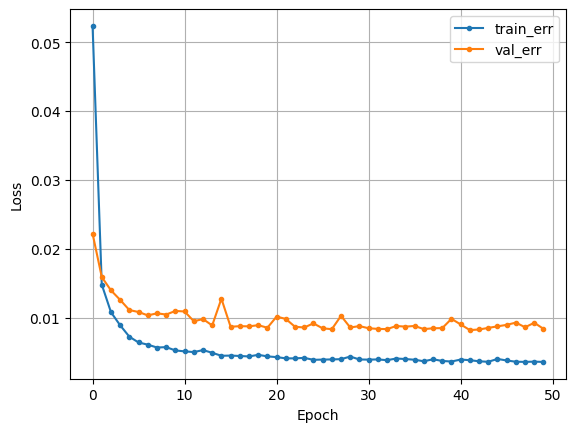

In [ ]:
hist = model03_01.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('RMSE :', np.sqrt(mean_squared_error(y_val2, pred)))
print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 [==============================] - 0s 2ms/step
RMSE : 2510.367107564698
MAE :  1667.7416910807292
MAPE :  5.4620362167214406e+17
R2 :  0.5118868264634293


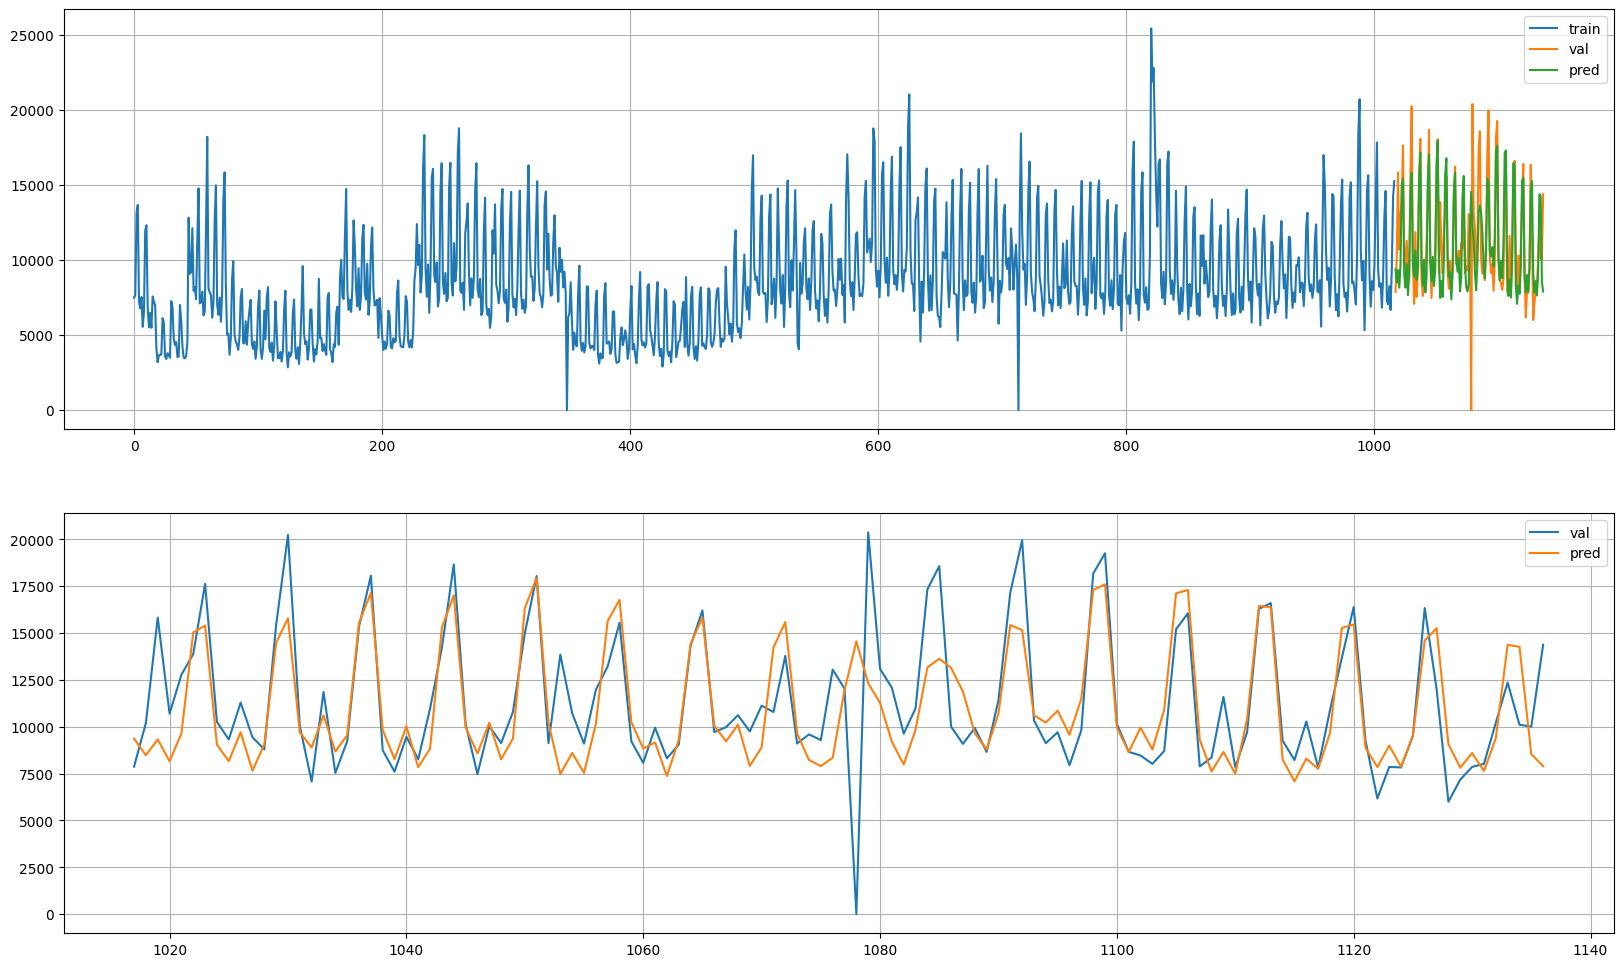

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [ ]:
def pipeLine(df, scaler_Y, timesteps = 7):
    target = 'After2'

    # X, y 분할
    X = df.drop(target, axis=1)
    y = df[target]

    # 스케일링
    scaler_X = MinMaxScaler()
    X = scaler_X.fit_transform(X)

    y = scaler_Y.fit_transform(y.values.reshape(-1,1))

    X = pd.DataFrame(X)
    y = pd.DataFrame(y)

    # 타임 스탬프를 기준으로 2차원 -> 3차원
    x2, y2 = temporalize(X, y, timesteps)

    X_train, X_val, y_train, y_val = train_test_split(x2, y2, test_size=60, shuffle=False)

    return X_train, X_val, y_train, y_val

In [ ]:
timesteps = 7
scaler_Y = MinMaxScaler()
X_train, X_val, y_train, y_val = pipeLine(sales_44_12, scaler_Y, timesteps)

* **모델링**

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 7, 64)             18688     
                                                                 
 lstm_1 (LSTM)               (None, 7, 32)             12416     
                                                                 
 lstm_2 (LSTM)               (None, 16)                3136      
                                                                 
 dense (Dense)               (None, 1)                 17        
                                                                 
Total params: 34257 (133.82 KB)
Trainable params: 34257 (133.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/100
34/34 [==============================] - 7s 41ms/step - loss: 0.0561 - val_loss: 0.0585 - lr: 0.0010
Epoch 2/100
34/34 [==================

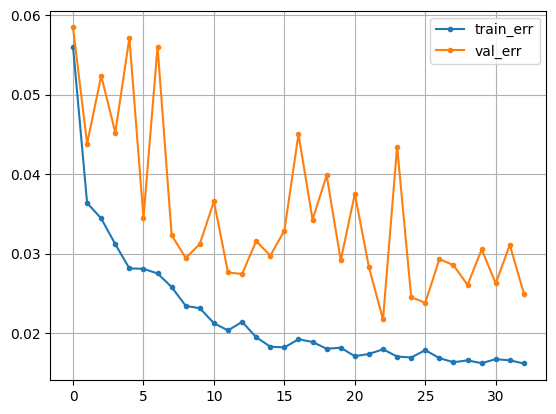

2/2 [==============================] - 1s 9ms/step
RMSE : 1962.6632005792926
MAE : 1400.399525130211
MAPE: 0.110198814843749
R2  : 0.5262402436593839


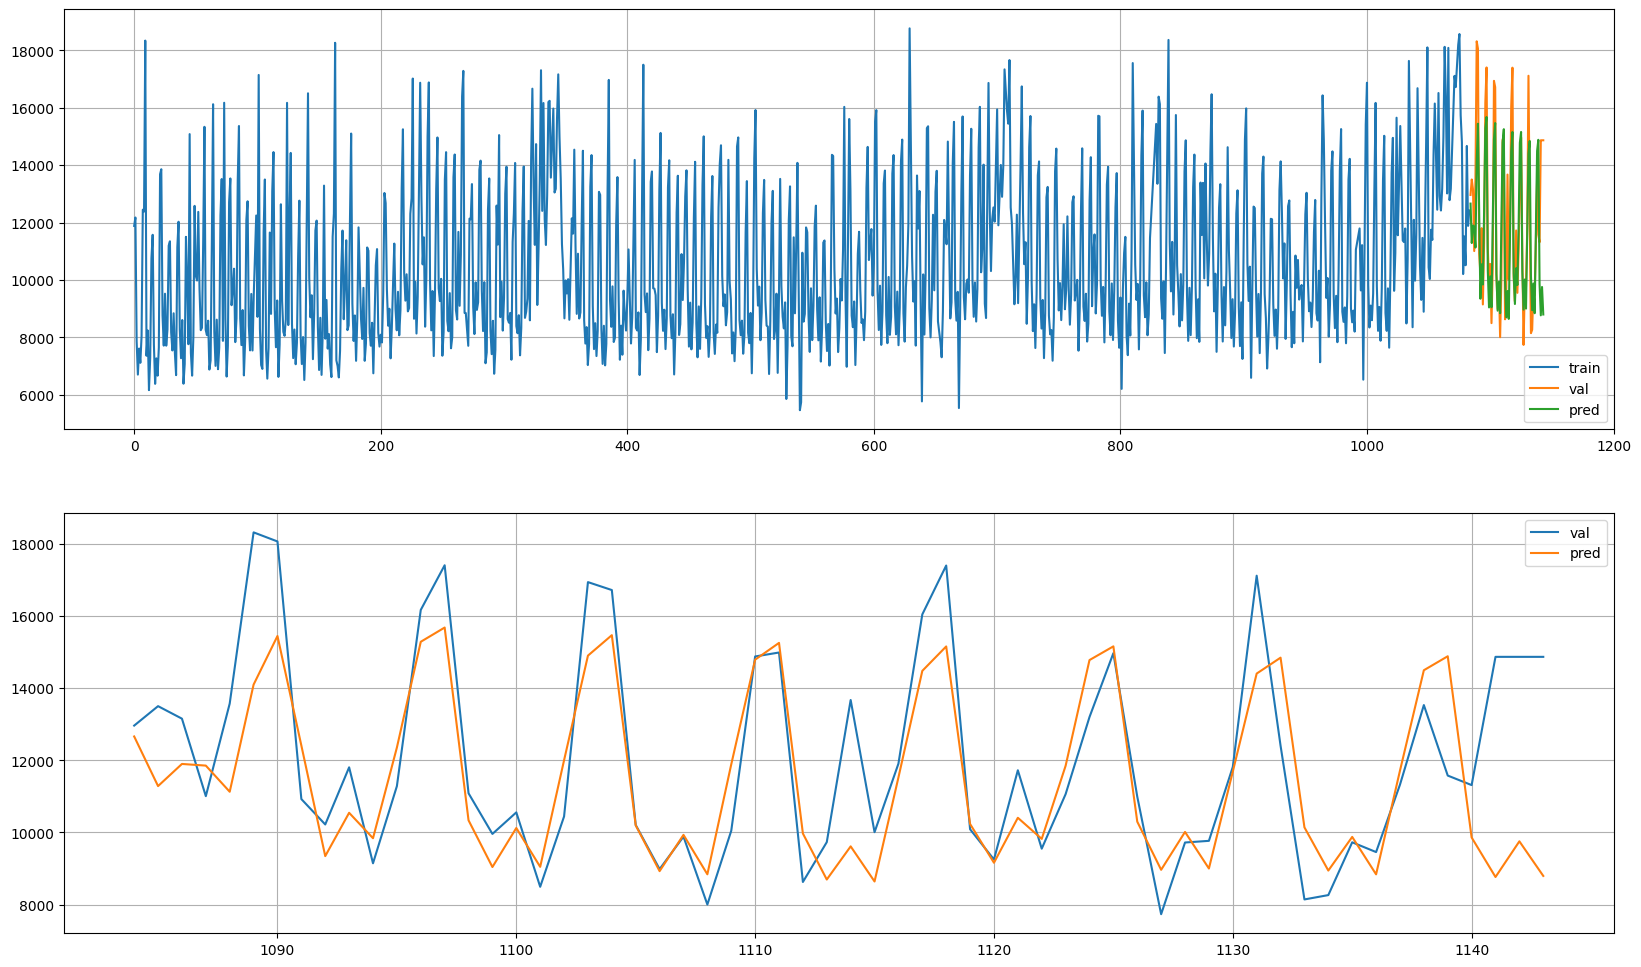

In [ ]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=10,
                   restore_best_weights=True,
                   verbose=1
                  )

lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=10,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.0001)

n_features = X_train.shape[2]

clear_session()

model_milk_LSTM2 = Sequential([LSTM(64, input_shape = (timesteps, n_features), return_sequences=True),
                     LSTM(32, return_sequences=True),
                     LSTM(16),
                     Dense(1)])

model_milk_LSTM2.compile(optimizer = Adam(learning_rate = 0.001), loss='mse')

model_milk_LSTM2.summary()

hist = model_milk_LSTM2.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[es, lr_reduction]).history

plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

pred = model_milk_LSTM2.predict(X_val)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_Y.inverse_transform(pred)
pred = pred.reshape(-1,)

# 평가
inverse_y_val = scaler_Y.inverse_transform(y_val).reshape(-1,)

print('RMSE :', mean_squared_error(inverse_y_val, pred, squared=False))
print('MAE :', mean_absolute_error(inverse_y_val, pred))
print('MAPE:', mean_absolute_percentage_error(inverse_y_val, pred))
print('R2  :', r2_score(inverse_y_val, pred))

# 그래프
inverse_y_train = scaler_Y.inverse_transform(y_train).reshape(-1,)
plot_model_result(inverse_y_train, inverse_y_val, pred)

### **3) 상품 : 42 - Agricultural products**

In [ ]:
timesteps = 1
x2, y2 = temporalize(x, y, timesteps) # 3차원 구조로 변환
x2.shape, y2.shape

((1155, 1, 8), (1155,))

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x2, y2, test_size= 60, shuffle = False)

In [ ]:
def flatten(X):
    flattened_X = np.empty((X.shape[0], X.shape[2]))
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return flattened_X

def scale(X, scaler):
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
    return X

# 2차원으로 변환하여 스케일러 생성
scaler = MinMaxScaler().fit(flatten(x_train))

# 3차원 데이터에 스테일러 적용
x_train_s3 = scale(x_train, scaler)
x_val_s3 = scale(x_val, scaler)

# y에 대한 스케일링(최적화를 위해)
scaler_y = MinMaxScaler()
y_train_s3 = scaler_y.fit_transform(y_train.reshape(-1,1))
y_val_s3 = scaler_y.transform(y_val.reshape(-1,1))

* **모델링**

In [ ]:
n_features = x_train_s3.shape[2]

clear_session()

model2_2 = Sequential([
    LSTM(64, input_shape = (timesteps, n_features), return_sequences = True),
    LSTM(32, return_sequences = True),
    LSTM(16, return_sequences = True),
    LSTM(4, return_sequences = True),
    Flatten(),
    Dense(1)
])

model2_2.compile(optimizer = Adam(learning_rate = 0.01), loss='mse', metrics=['mse'])
model2_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 64)             18688     
                                                                 
 lstm_1 (LSTM)               (None, 1, 32)             12416     
                                                                 
 lstm_2 (LSTM)               (None, 1, 16)             3136      
                                                                 
 lstm_3 (LSTM)               (None, 1, 4)              336       
                                                                 
 flatten (Flatten)           (None, 4)                 0         
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 34581 (135.08 KB)
Trainable params: 34581 

In [ ]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_mse', patience=5, restore_best_weights=True)
history = model2_2.fit(x_train_s3, y_train_s3, epochs=100, validation_split=.2, callbacks=[early_stopping])

Epoch 1/100
28/28 [==============================] - 10s 71ms/step - loss: 0.0762 - mse: 0.0762 - val_loss: 0.0629 - val_mse: 0.0629
Epoch 2/100
28/28 [==============================] - 0s 8ms/step - loss: 0.0311 - mse: 0.0311 - val_loss: 0.0534 - val_mse: 0.0534
Epoch 3/100
28/28 [==============================] - 0s 8ms/step - loss: 0.0312 - mse: 0.0312 - val_loss: 0.0522 - val_mse: 0.0522
Epoch 4/100
28/28 [==============================] - 0s 10ms/step - loss: 0.0297 - mse: 0.0297 - val_loss: 0.0402 - val_mse: 0.0402
Epoch 5/100
28/28 [==============================] - 0s 9ms/step - loss: 0.0202 - mse: 0.0202 - val_loss: 0.0257 - val_mse: 0.0257
Epoch 6/100
28/28 [==============================] - 0s 9ms/step - loss: 0.0141 - mse: 0.0141 - val_loss: 0.0217 - val_mse: 0.0217
Epoch 7/100
28/28 [==============================] - 0s 9ms/step - loss: 0.0146 - mse: 0.0146 - val_loss: 0.0222 - val_mse: 0.0222
Epoch 8/100
28/28 [==============================] - 0s 9ms/step - loss: 0.0141 

In [ ]:
pred = model2_2.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

2/2 [==============================] - 1s 7ms/step


In [ ]:
# 평가
print('MAE :', round(mean_absolute_error(y_val, pred), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_val, pred)),2)
print('MAPE:', mean_absolute_percentage_error(y_val, pred))
print('R2  :', round(r2_score(y_val, pred),2))
print('RMSE :', round(np.sqrt(mean_squared_error(y_val, pred)), 2))

MAE : 12.56
MAPE: 0 2
MAPE: 0.15363362344042347
R2  : -0.08
RMSE : 15.72


## **(2) CNN 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [ ]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = preproc3d(df_3, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(0.0, 25413.0, (1017, 7, 17), (120, 7, 17))

* **모델링**

In [ ]:
from tensorflow.keras.layers import Conv1D, MaxPooling1D

In [ ]:
clear_session()

_, ts, nfeat = x_train.shape

model03_01 = Sequential([
    Conv1D(128, 3, input_shape=(ts, nfeat), activation='relu', padding='same'),
    Conv1D(128, 3, activation='relu', padding='same'),
    Conv1D(64, 3, activation='relu', padding='same'),
    Conv1D(64, 3, activation='relu', padding='same'),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1)
])

model03_01.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 128)            6656      
                                                                 
 conv1d_1 (Conv1D)           (None, 7, 128)            49280     
                                                                 
 conv1d_2 (Conv1D)           (None, 7, 64)             24640     
                                                                 
 conv1d_3 (Conv1D)           (None, 7, 64)             12352     
                                                                 
 flatten (Flatten)           (None, 448)               0         
                                                                 
 dense (Dense)               (None, 128)               57472     
                                                                 
 dense_1 (Dense)             (None, 64)                8

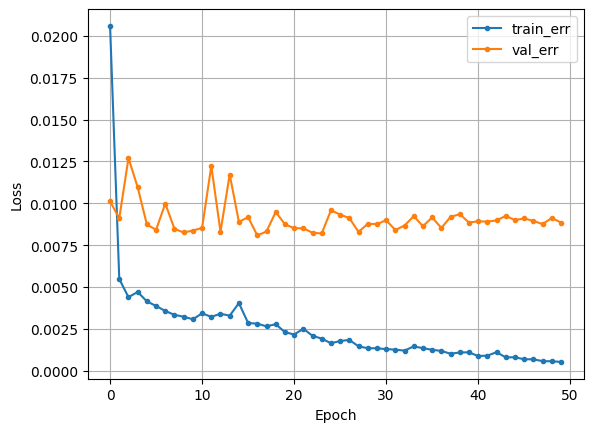

In [ ]:
model03_01.compile(optimizer = 'adam', loss = 'mse')
hist = model03_01.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_01.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('RMSE :', np.sqrt(mean_squared_error(y_val2, pred)))
print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 [==============================] - 0s 7ms/step
RMSE : 2522.1432040257437
MAE :  1683.4537272135417
MAPE :  5.0850254076810797e+17
R2 :  0.5072966214289787


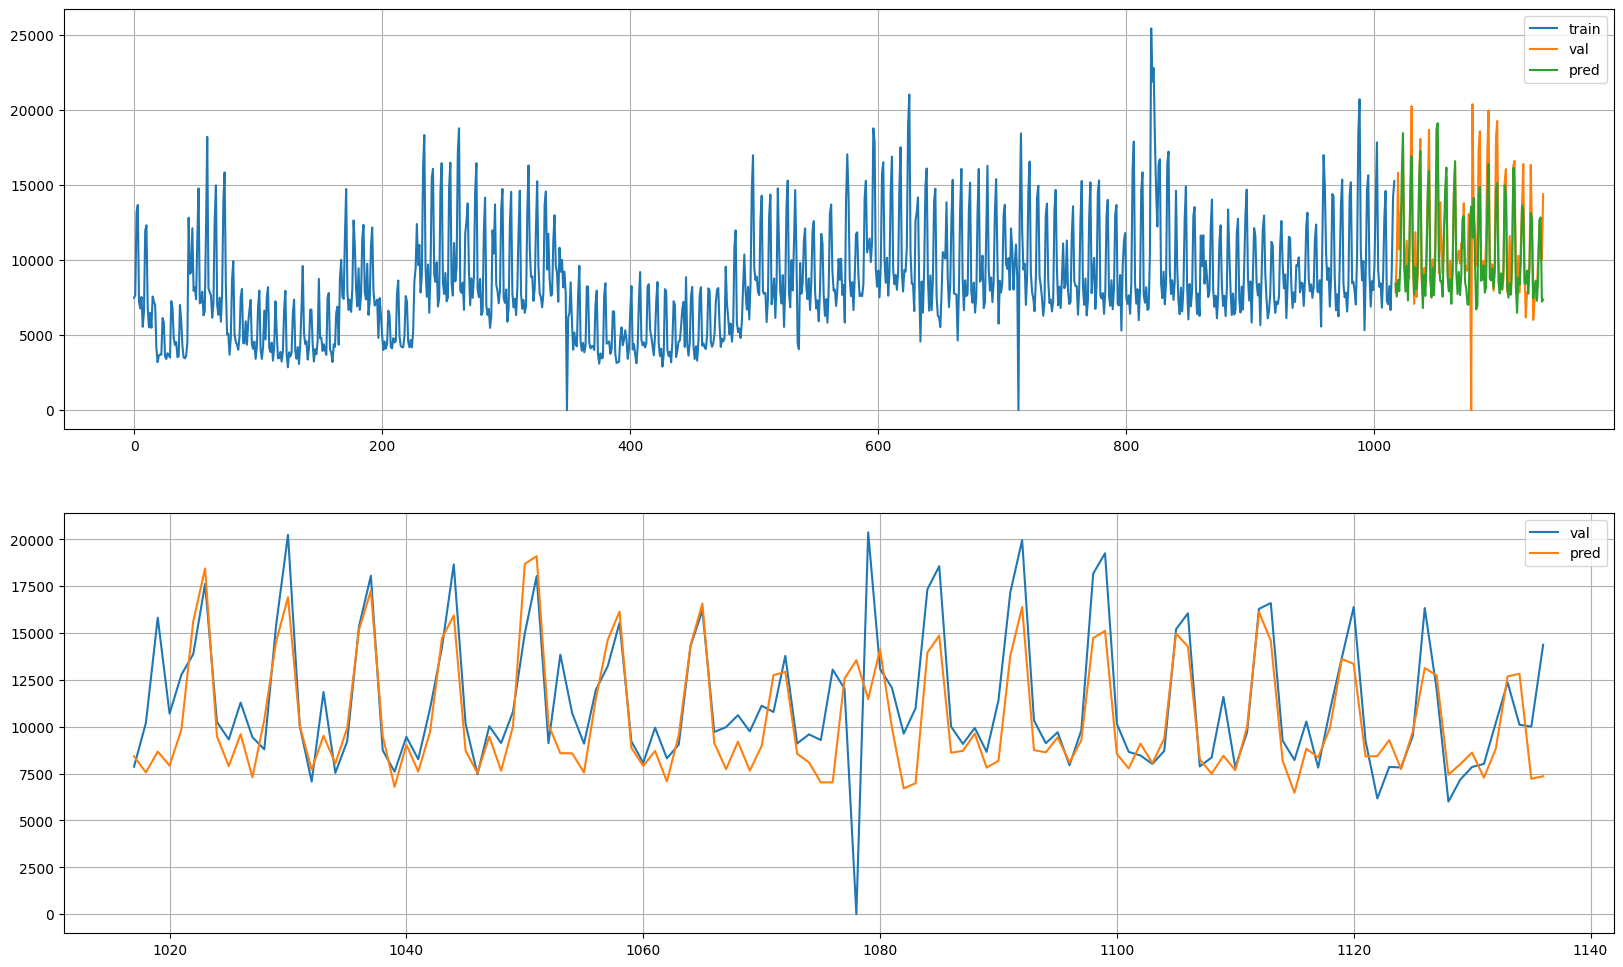

In [ ]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [ ]:
def pipeLine(df, scaler_Y, timesteps = 7):
    target = 'After2'

    # X, y 분할
    X = df.drop(target, axis=1)
    y = df[target]

    # 스케일링
    scaler_X = MinMaxScaler()
    X = scaler_X.fit_transform(X)

    y = scaler_Y.fit_transform(y.values.reshape(-1,1))

    X = pd.DataFrame(X)
    y = pd.DataFrame(y)

    # 타임 스탬프를 기준으로 2차원 -> 3차원
    x2, y2 = temporalize(X, y, timesteps)

    X_train, X_val, y_train, y_val = train_test_split(x2, y2, test_size=60, shuffle=False)

    return X_train, X_val, y_train, y_val

In [ ]:
timesteps = 7
scaler_Y = MinMaxScaler()
X_train, X_val, y_train, y_val = pipeLine(sales_44_12, scaler_Y, timesteps)

In [ ]:
es = EarlyStopping(monitor='val_loss',
                   min_delta=0,
                   patience=10,
                   restore_best_weights=True,
                   verbose=1
                  )

In [ ]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss',
                                 patience=4,
                                 verbose=1,
                                 factor=0.5,
                                 min_lr=0.000001)

* **모델링**

In [ ]:
n_features = X_train.shape[2]

clear_session()

model_milk_CNN = Sequential([Conv1D(128, 5, input_shape = (timesteps, n_features), activation='relu', padding = 'same'),
                     Conv1D(32, 5, activation='relu', padding = 'same'),
                     Conv1D(32, 5, activation='relu', padding = 'same'),
                     Conv1D(16, 5, activation='relu', padding = 'same'),
                     Flatten(),
                     Dense(32),
                     Dense(1)])

model_milk_CNN.compile(optimizer= Adam(learning_rate = 0.001) , loss='mse')

In [ ]:
model_milk_CNN.summary()

In [ ]:
hist = model_milk_CNN.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[es, lr_reduction]).history

In [ ]:
plt.plot(hist['loss'], label = 'train_err', marker = '.')
plt.plot(hist['val_loss'], label = 'val_err', marker = '.')
plt.grid()
plt.legend()
plt.show()

In [ ]:
pred = model_milk_CNN.predict(X_val)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_Y.inverse_transform(pred)
pred = pred.reshape(-1,)

In [ ]:
# 평가
inverse_y_val = scaler_Y.inverse_transform(y_val).reshape(-1,)

print('RMSE :', mean_squared_error(inverse_y_val, pred, squared=False))
print('MAE :', mean_absolute_error(inverse_y_val, pred))
print('MAPE:', mean_absolute_percentage_error(inverse_y_val, pred))
print('R2  :', r2_score(inverse_y_val, pred))

In [ ]:
inverse_y_train = scaler_Y.inverse_transform(y_train).reshape(-1,)
plot_model_result(inverse_y_train, inverse_y_val, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [ ]:
x_train.shape, x_val.shape, y_train.shape, y_val.shape

((1095, 1, 8), (60, 1, 8), (1095,), (60,))

In [ ]:
x_train_s3.shape, x_val_s3.shape, y_train_s3.shape, y_val_s3.shape

((1095, 1, 8), (60, 1, 8), (1095, 1), (60, 1))

In [ ]:
n_features = x_train_s3.shape[2]

clear_session()

model3 = Sequential([Conv1D(32, 5, input_shape = (timesteps, n_features), activation='relu', padding = 'same'),
                     Conv1D(8, 3, input_shape = (timesteps, n_features), activation='relu', padding = 'same'),
                    Flatten(),
                    Dense(1)])

model3.compile(optimizer= Adam(learning_rate = 0.01) ,loss='mse', metrics=['mse'])
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 32)             1312      
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 8)              776       
                                                                 
 flatten (Flatten)           (None, 8)                 0         
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 2097 (8.19 KB)
Trainable params: 2097 (8.19 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


* **모델링**

In [ ]:
hist = model3.fit(x_train_s3, y_train_s3, epochs=30, validation_split=.2).history

Epoch 1/30
28/28 [==============================] - 2s 16ms/step - loss: 0.0664 - mse: 0.0664 - val_loss: 0.0545 - val_mse: 0.0545
Epoch 2/30
28/28 [==============================] - 0s 7ms/step - loss: 0.0285 - mse: 0.0285 - val_loss: 0.0455 - val_mse: 0.0455
Epoch 3/30
28/28 [==============================] - 0s 5ms/step - loss: 0.0263 - mse: 0.0263 - val_loss: 0.0369 - val_mse: 0.0369
Epoch 4/30
28/28 [==============================] - 0s 5ms/step - loss: 0.0227 - mse: 0.0227 - val_loss: 0.0324 - val_mse: 0.0324
Epoch 5/30
28/28 [==============================] - 0s 5ms/step - loss: 0.0183 - mse: 0.0183 - val_loss: 0.0305 - val_mse: 0.0305
Epoch 6/30
28/28 [==============================] - 0s 5ms/step - loss: 0.0156 - mse: 0.0156 - val_loss: 0.0316 - val_mse: 0.0316
Epoch 7/30
28/28 [==============================] - 0s 5ms/step - loss: 0.0142 - mse: 0.0142 - val_loss: 0.0319 - val_mse: 0.0319
Epoch 8/30
28/28 [==============================] - 0s 4ms/step - loss: 0.0135 - mse: 0.0

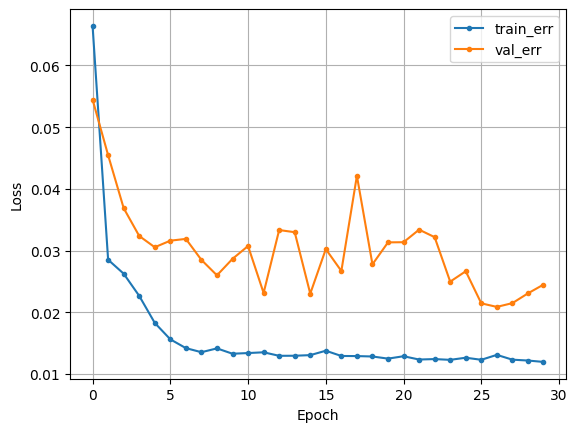

In [ ]:
dl_history_plot(hist)

In [ ]:
pred = model3.predict(x_val_s3)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_y.inverse_transform(pred)
pred = pred.reshape(-1,)

2/2 [==============================] - 0s 72ms/step


In [ ]:
# 평가
print('MAE :', round(mean_absolute_error(y_val, pred), 2))
print('MAPE:', round(mean_absolute_percentage_error(y_val, pred)),2)
print('R2  :', round(r2_score(y_val, pred),2))
print('RMSE :', round(np.sqrt(mean_squared_error(y_val, pred)), 2))

MAE : 13.79
MAPE: 0 2
R2  : -0.24
RMSE : 16.86


In [ ]:
# train에 대한 잔차 진단.
pred_tr = model3.predict(x_train_s3)

pred_tr = scaler_y.inverse_transform(pred_tr)
pred_tr = pred_tr.reshape(-1,)

# 잔차 : 실제값에서 예측값을 빼서 계산
residuals = y_train - pred_tr

35/35 [==============================] - 0s 3ms/step


* 정규성 검정(> 0.05) :  0.09453
* 정상성 검정(< 0.05) :  0.03578
* 자기상관성 확인(ACF, PACF)


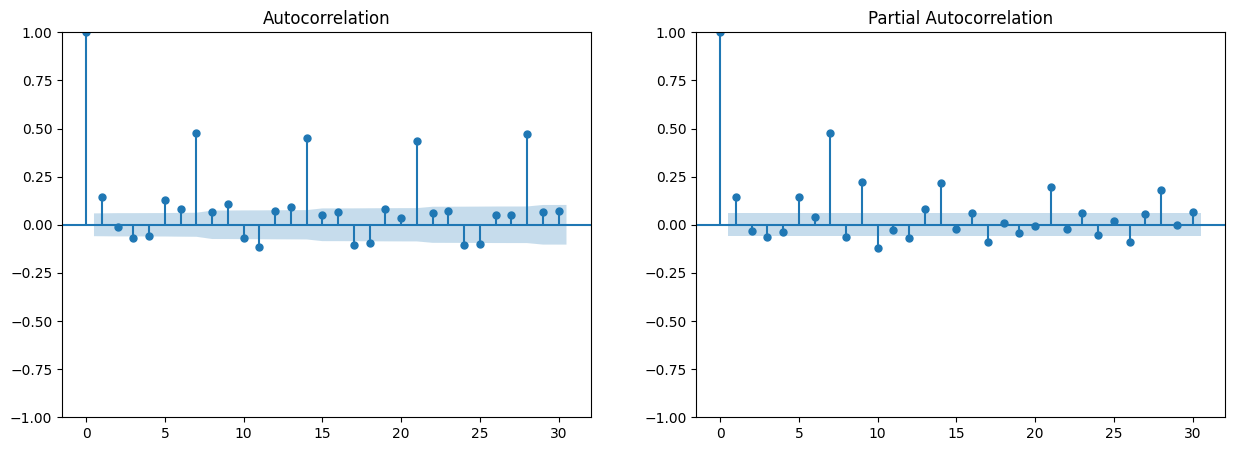

In [ ]:
residual_diag(residuals)

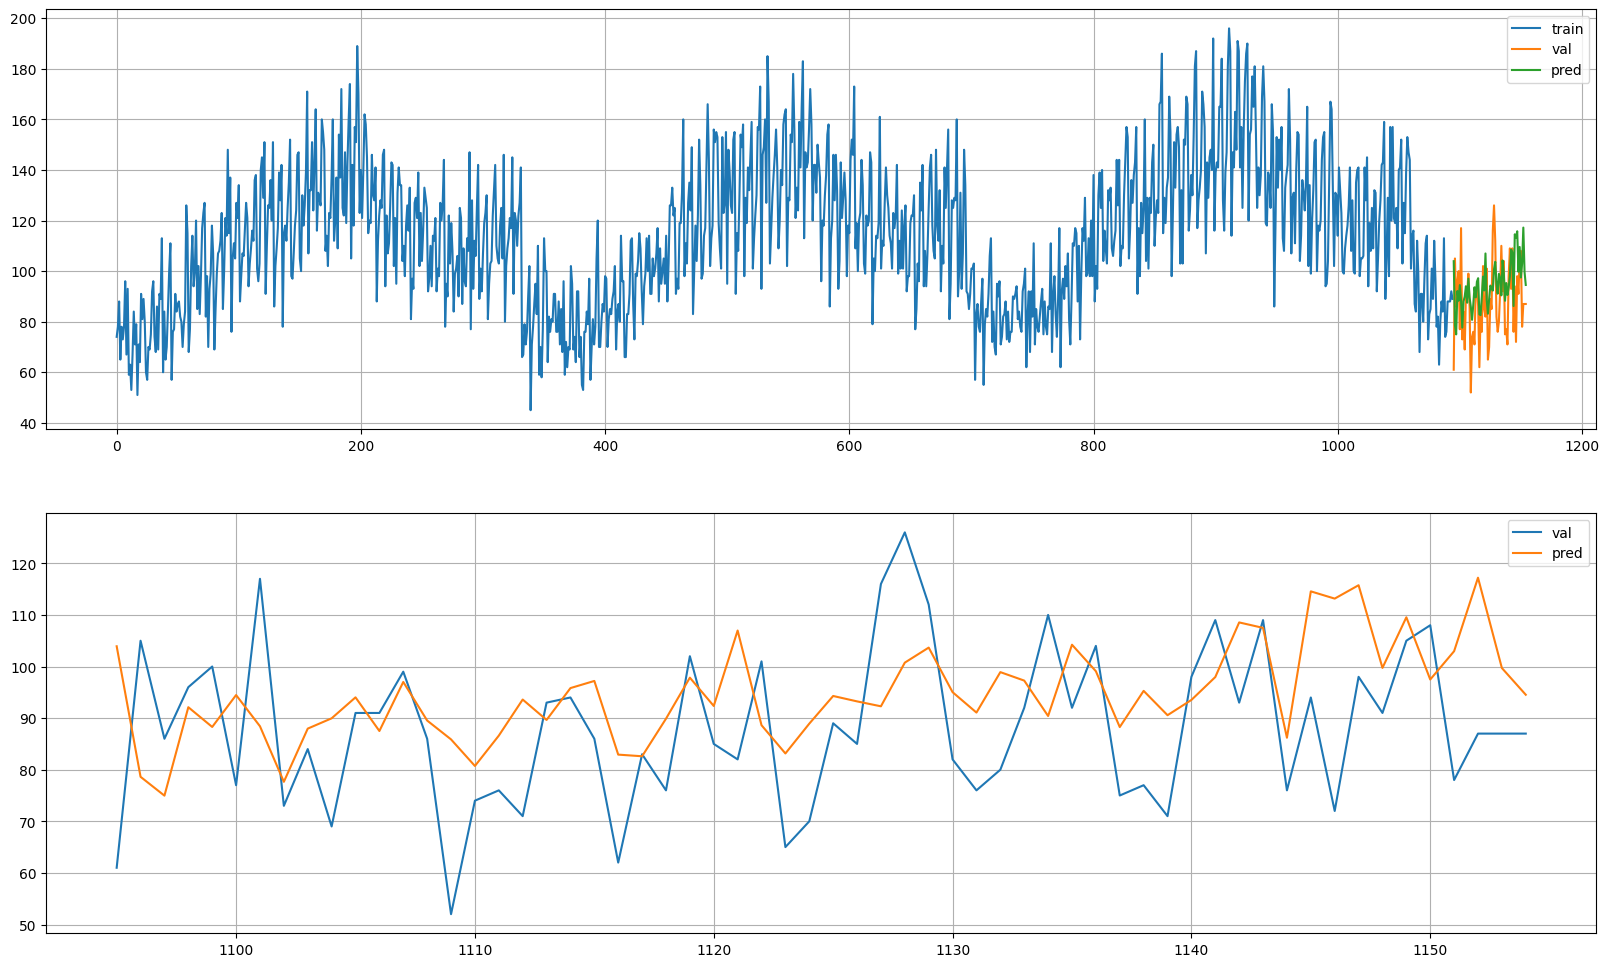

In [ ]:
plot_model_result(y_train, y_val, pred)

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * test set으로 파이프라인 함수를 테스트 해 봅시다.

## **(1) 파이프라인 함수 생성**

In [ ]:
# 주의!
# product_ID 값 넣기
def preprocessing4predict(oil_price_test, orders_test, sales_test, product_ID = 3, timesteps = 1, scaler=scaler):

    # 1. merge
    sales_test = sales_test.loc[(sales_test['Store_ID']==44) & (sales_test['Product_ID']==product_ID)]
    df = pd.merge(sales_test, oil_price_test, how='left')
    df = pd.merge(df, orders_test,  how='left')

    # 2. preprocessing
    ## 2-1. 파생변수 생성
    df['year'] = df['Date'].dt.year
    df['month'] = df['Date'].dt.month
    df['day'] = df['Date'].dt.day
    df['dayofweek'] = df['Date'].dt.dayofweek
    df['Qty_diff'] = df['Qty'].diff()

    ## 2-2. 불필요한 변수 제거
    drop_cols = ['Store_ID', 'Product_ID']
    df = df.drop(drop_cols, axis=1)

    ## 2-3. 결측값 처리
    df['WTI_Price'] = df['WTI_Price'].interpolate(method='linear').fillna(method='bfill')
    df['Qty_diff'] = df['Qty_diff'].fillna(method='bfill')

    # ?
    df['y'] = df['Qty'].shift(-2)
    df['y'] = df['y'].interpolate(method='linear')

    # 3. x_test, y_test 분리
    target = 'y'

    x_test = df.drop(['Date', target], axis = 1)
    y_test = df.loc[:,target]

    # 4. scaler
    x_test, y_test = temporalize(x_test, y_test, timesteps) # 2차원 --> 3차원
    x_test_s = scale(x_test, scaler)
    return x_test, y_test

## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

In [ ]:
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')
products = pd.read_csv(path + 'test/products.csv')
stores = pd.read_csv(path + 'test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

In [ ]:
x_test, y_test = preprocessing4predict(oil_price_test, orders_test, sales_test)

#### Product 3 :  LSTM

In [ ]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_01.predict(x_test)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_test * (y_max - y_min) + y_min

print('RMSE :', np.sqrt(mean_squared_error(y_val2, pred)))
print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

1/1 [==============================] - 0s 17ms/step
RMSE : 2235.147722131987
MAE :  2010.6288452148438
MAPE :  0.22090710774894912
R2 :  -1.0608311694881745


#### Product 12 : CNN

In [ ]:
timesteps = 7
scaler_Y = MinMaxScaler()

x_test, y_test = preprocessing4predict_12(sales_test, oil_price_test, orders_test, products, scaler_Y, timesteps)
x_test.shape, y_test.shape

In [ ]:
pred = model_milk_CNN.predict(x_test)

# 예측 결과를 원래 스케일로 돌려 놓기
pred = scaler_Y.inverse_transform(pred)
pred = pred.reshape(-1,)

In [ ]:
# 평가
inverse_y_test = scaler_Y.inverse_transform(y_test).reshape(-1,)

print('RMSE :', mean_squared_error(inverse_y_test, pred, squared=False))
print('MAE :', mean_absolute_error(inverse_y_test, pred))
print('MAPE:', mean_absolute_percentage_error(inverse_y_test, pred))
print('R2  :', r2_score(inverse_y_test, pred))

In [ ]:
plot_model_result(None, inverse_y_test, pred)

#### Product 44 :  LSTM (4-Layer)

In [ ]:
pred_test = model2_2.predict(x_test)

# 예측 결과를 원래 스케일로 돌려 놓기
pred_test = scaler_y.inverse_transform(pred_test)
pred_test = pred_test.reshape(-1,)

1/1 [==============================] - 0s 21ms/step


In [ ]:
# 평가
print('MAE :', mean_absolute_error(y_test, pred_test))
print('MAPE:', mean_absolute_percentage_error(y_test, pred_test))
print('R2  :', r2_score(y_test, pred_test))
print('RMSE :', np.sqrt(mean_squared_error(y_test, pred_test)))

MAE : 10.166942227271296
MAPE: 0.09320107930044441
R2  : 0.4550372190015759
RMSE : 12.52006140102834


# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수가 제공됩니다.
        * 필요하다면 해당 함수를 수정해서 사용할 수 있습니다.
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_sacled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [ ]:
def inv_simulator(y, pred, safe_stock, price) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**


#### 1. Product_3

In [ ]:
inv_simulator(y_val2, pred, 4008, 8)

일평균 재고량     : 8101.917
일평균 재고 금액  : 64815.336
일평균 재고회전율 : 1.211
기회손실 수량     : 0.0


,y,pred,base_stock,close_stock,order,receive,lost
0,9596.0,7846.0,13604,4008,7555,9596,0.0
1,8146.0,7354.0,12154,4008,8342,8146,0.0
2,10130.0,7555.0,11563,1433,11539,7555,0.0
3,9775.0,8342.0,9775,0,11746,8342,0.0
4,6195.0,8964.0,11539,5344,5943,11539,0.0
5,10385.0,7738.0,17090,6705,5116,11746,0.0


#### 2. Product_12

In [ ]:
inv_simulator(inverse_y_test, pred5, 10580, 6)

일평균 재고량     : 15517.955
일평균 재고 금액  : 93107.73
일평균 재고회전율 : 0.887
기회손실 수량     : 0.0


,y,pred,base_stock,close_stock,order,receive,lost
0,9083.0,8940.0,19663,10580,11610,9083.0,0.0
1,14392.0,11916.0,24972,10580,9293,14392.0,0.0
2,16478.0,11610.0,22190,5712,14447,11610.0,0.0
3,8715.0,9293.0,15005,6290,12352,9293.0,0.0
4,7505.0,9579.0,20737,13232,4403,14447.0,0.0
5,10453.0,8062.0,25584,15131,5026,12352.0,0.0
6,8592.0,7055.0,19534,10942,12274,4403.0,0.0
7,11463.0,9577.0,15968,4505,19705,5026.0,0.0
8,16763.0,12636.0,16779,16,20901,12274.0,0.0
9,16948.0,13630.0,19721,2773,17314,19705.0,0.0


#### 3. Product_44

In [ ]:
print("LSTM 재고금액 평가")
inv_simulator(y_test, pred_test, 73, 5)

LSTM 재고금액 평가
일평균 재고량     : 131.224
일평균 재고 금액  : 656.1199999999999
일평균 재고회전율 : 0.967
기회손실 수량     : 0.0


,y,pred,base_stock,close_stock,order,receive,lost
0,106.0,114.0,179,73,132,106,0.0
1,144.0,149.0,217,73,119,144,0.0
2,152.0,132.0,205,53,138,132,0.0
3,108.0,119.0,172,64,124,119,0.0
4,89.0,118.0,202,113,64,138,0.0
5,114.0,115.0,237,123,71,124,0.0
6,110.0,104.0,187,77,135,64,0.0
7,101.0,121.0,148,47,149,71,0.0
8,131.0,139.0,182,51,135,135,0.0
9,145.0,123.0,200,55,128,149,0.0
